##IMPORTANDO BIBLIOTECAS

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


##CRIAÇÃO TABELA PARA EXPLORAÇÃO

In [0]:
raw_df = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv("dbfs:/FileStore/tables/database_gb.csv")
)

raw_df.printSchema()


root
 |-- ano_mes: date (nullable = true)
 |-- cod_material: string (nullable = true)
 |-- des_material: string (nullable = true)
 |-- des_familia: string (nullable = true)
 |-- cod_tipo_material: string (nullable = true)
 |-- unidade_medida: string (nullable = true)
 |-- des_categoria_demanda: string (nullable = true)
 |-- vlr_consumo_realizado: double (nullable = true)
 |-- qtd_realizada: double (nullable = true)
 |-- qtd_prevista: double (nullable = true)



In [0]:
%sql
CREATE DATABASE IF NOT EXISTS SANDBOX

In [0]:
(
    raw_df
    .write
    .mode("overwrite")
    .format("delta")
    .saveAsTable("sandbox.consumo_material_base")
)


##ACURACIDADE DOS DADOS

In [0]:
%sql

SELECT 
    MIN(ano_mes) as data_inicio,
    MAX(ano_mes) as data_fim,
    COUNT(DISTINCT cod_material) as total_skus,
    COUNT(DISTINCT des_familia) as total_familias,
    COUNT(DISTINCT des_categoria_demanda) as categorias_demanda
FROM sandbox.consumo_material_base;


SELECT 
    COUNT(*) as total_linhas,
    SUM(CASE WHEN qtd_realizada IS NULL THEN 1 ELSE 0 END) as nulos_realizado,
    SUM(CASE WHEN qtd_prevista IS NULL THEN 1 ELSE 0 END) as nulos_previsto
FROM sandbox.consumo_material_base;

total_linhas,nulos_realizado,nulos_previsto
11171,0,0


In [0]:
# Cálculo do Erro Financeiro Absoluto (Onde o erro dói mais no bolso)
df_validacao = spark.sql("""
    SELECT 
        des_familia,
        cod_material,
        SUM(ABS(qtd_realizada - qtd_prevista) * (vlr_consumo_realizado / NULLIF(qtd_realizada, 0))) as erro_financeiro_abs
    FROM sandbox.consumo_material_base
    GROUP BY 1, 2
    ORDER BY erro_financeiro_abs DESC
    LIMIT 10
""").display()

des_familia,cod_material,erro_financeiro_abs
DES_030EEC2D,COD_FEDCC140,7.36176035120932E7
DES_030EEC2D,COD_C253EBBA,5.572410110639686E7
DES_D8183E10,COD_4E8CC0F6,5.1832974875869915E7
DES_D8183E10,COD_3DA87CDF,4.742897048440848E7
DES_D5109625,COD_C891F342,4.0731769022751816E7
DES_82AD34A6,COD_C441C7D4,3.74658409913351E7
DES_82AD34A6,COD_2141522D,3.543703722502835E7
DES_82AD34A6,COD_9682754D,3.233540568176419E7
DES_82AD34A6,COD_6DDAB865,2.970103195518607E7
DES_D8183E10,COD_ABFDBFBA,2.6498191179140974E7


In [0]:
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt


In [0]:
import pyspark.sql.functions as F

df = spark.table("sandbox.consumo_material_base")

df.select(
    F.sum("vlr_consumo_realizado").alias("consumo_total")
).show()


+--------------------+
|       consumo_total|
+--------------------+
|4.2599544058799996E9|
+--------------------+



In [0]:
pareto_df = (
    df.groupBy("des_material")
      .agg(F.sum("vlr_consumo_realizado").alias("consumo"))
      .orderBy(F.desc("consumo"))
)

pareto_pd = pareto_df.toPandas()

pareto_pd["acumulado"] = pareto_pd["consumo"].cumsum()
pareto_pd["acumulado_pct"] = pareto_pd["acumulado"] / pareto_pd["consumo"].sum()


##FORECAST PREVISIBILIDADE

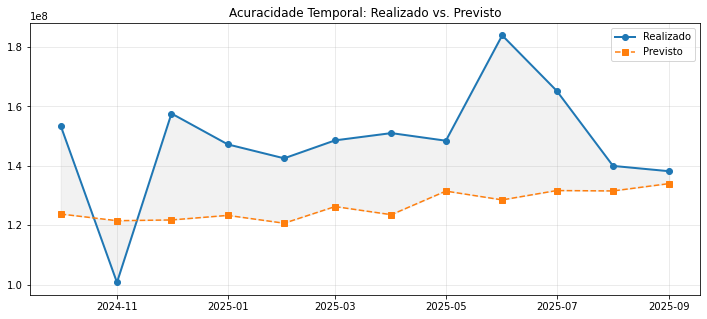

In [0]:
df_trend = spark.sql("""
    SELECT ano_mes, 
           SUM(qtd_realizada) as total_realizado,
           SUM(qtd_prevista) as total_previsto
    FROM sandbox.consumo_material_base
    GROUP BY ano_mes ORDER BY ano_mes
""").toPandas()

plt.figure(figsize=(12, 5))
plt.plot(df_trend['ano_mes'], df_trend['total_realizado'], label='Realizado', marker='o', linewidth=2)
plt.plot(df_trend['ano_mes'], df_trend['total_previsto'], label='Previsto', linestyle='--', marker='s')
plt.fill_between(df_trend['ano_mes'], df_trend['total_realizado'], df_trend['total_previsto'], color='gray', alpha=0.1)
plt.title('Acuracidade Temporal: Realizado vs. Previsto')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

##WMAPE - EVOLUÇÃO DO ERRO

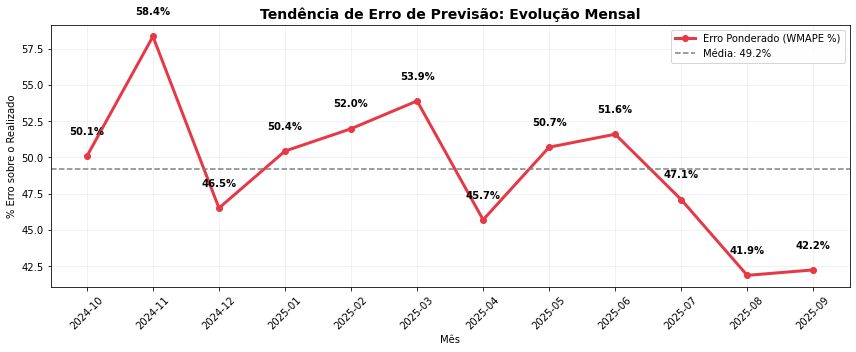

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. SQL Corrigido (Unificando a lógica WMAPE para coerência entre os slides)
df_erro_mensal = spark.sql("""
    SELECT 
        date_format(ano_mes, 'yyyy-MM') as mes,
        (SUM(ABS(qtd_realizada - qtd_prevista)) / SUM(NULLIF(qtd_realizada, 0))) * 100 as wmape
    FROM sandbox.consumo_material_base
    WHERE qtd_realizada > 0
    GROUP BY 1 
    ORDER BY 1
""").toPandas()

# 2. Criando o gráfico
plt.figure(figsize=(12, 5))

# Corrigido: Usando a coluna 'wmape' que foi definida no SQL
plt.plot(df_erro_mensal['mes'], df_erro_mensal['wmape'], 
         marker='o', color='#E63946', linewidth=3, label='Erro Ponderado (WMAPE %)')

# Estética Executiva
plt.title('Tendência de Erro de Previsão: Evolução Mensal', fontsize=14, fontweight='bold')
plt.xlabel('Mês')
plt.ylabel('% Erro sobre o Realizado')

# Linha de média histórica para análise de estabilidade
media_periodo = df_erro_mensal['wmape'].mean()
plt.axhline(media_periodo, color='gray', linestyle='--', label=f'Média: {media_periodo:.1f}%')

plt.grid(True, alpha=0.2)
plt.xticks(rotation=45)
plt.legend()

# Adicionando os valores em cima dos pontos para facilitar a leitura no slide
for i, v in enumerate(df_erro_mensal['wmape']):
    plt.text(i, v + 1.5, f"{v:.1f}%", ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

##PARETO

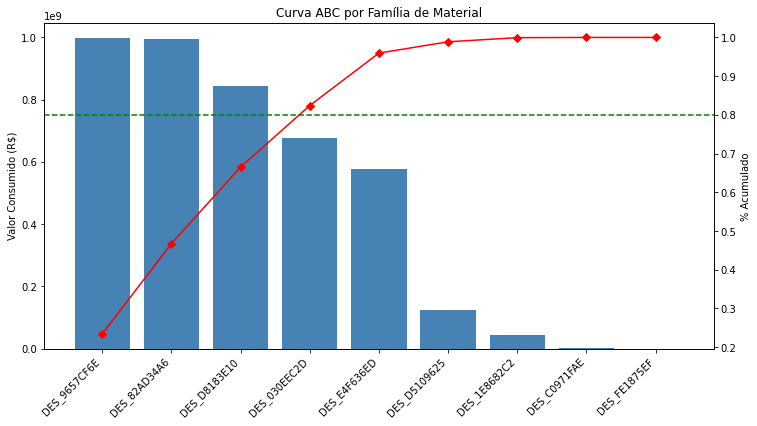

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregando os dados processados via SQL
df_abc = spark.sql("""
    WITH valorizacao AS (
        SELECT des_familia, SUM(vlr_consumo_realizado) as valor_total
        FROM sandbox.consumo_material_base
        GROUP BY 1 ORDER BY valor_total DESC
    )
    SELECT *, 
           SUM(valor_total) OVER (ORDER BY valor_total DESC) / SUM(valor_total) OVER () as pct_acumulado
    FROM valorizacao
""").toPandas()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras para valor
ax1.bar(df_abc['des_familia'], df_abc['valor_total'], color='steelblue')
ax1.set_ylabel('Valor Consumido (R$)')
plt.xticks(rotation=45, ha='right')

# Linha para acumulado
ax2 = ax1.twinx()
ax2.plot(df_abc['des_familia'], df_abc['pct_acumulado'], color='red', marker='D', ms=5)
ax2.axhline(y=0.8, color='green', linestyle='--') # Limite Curva A
ax2.set_ylabel('% Acumulado')

plt.title('Curva ABC por Família de Material')
plt.show()

##WMAPE POR FAMÍLIA

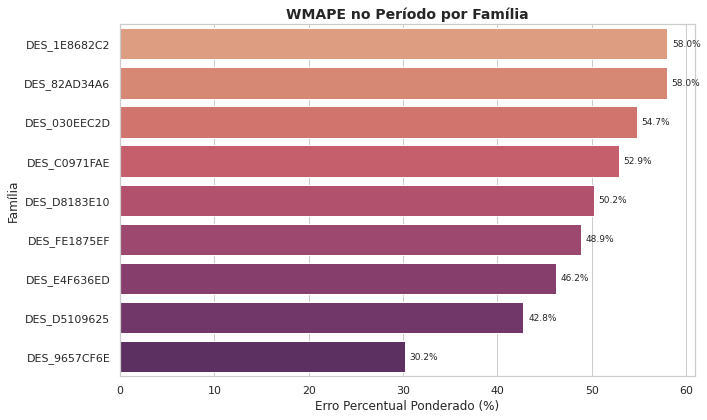

In [0]:
df = spark.table("sandbox.consumo_material_base")

# 2. Calcular MAPE ponderado por família
# Fórmula: sum(|Real - Previsto|) / sum(Real)
mape_ponderado_df = (
    df.filter(F.col("qtd_realizada") > 0)
      .groupBy("des_familia")
      .agg(
          (
              F.sum(F.abs(F.col("qtd_realizada") - F.col("qtd_prevista"))) /
              F.sum("qtd_realizada") * 100
          ).alias("mape_ponderado")
      )
      .orderBy(F.desc("mape_ponderado"))
)

# 3. Converter para pandas
mape_pd = mape_ponderado_df.toPandas()

# 4. Plotar gráfico (ranking)
plt.figure(figsize=(10,6))

sns.barplot(
    data=mape_pd,
    y="des_familia",
    x="mape_ponderado",
    palette="flare"
)

plt.title("WMAPE no Período por Família", fontsize=14, fontweight="bold")
plt.xlabel("Erro Percentual Ponderado (%)")
plt.ylabel("Família")

# Labels nas barras
for i, v in enumerate(mape_pd["mape_ponderado"]):
    plt.text(v + 0.5, i, f"{v:.1f}%", va="center", fontsize=9)

plt.tight_layout()
plt.show()


##ERRO EM VOLUME ABSOLUTO

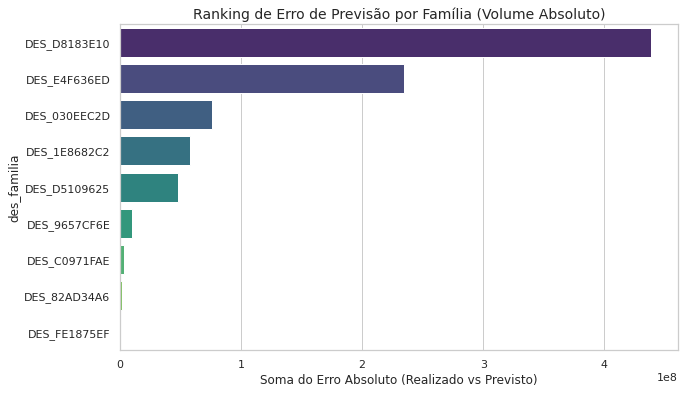

In [0]:
df = spark.read.table("sandbox.consumo_material_base").toPandas()
df['ano_mes'] = pd.to_datetime(df['ano_mes'])

# Calculando a variação absoluta para ver quem erra mais a mão
df['erro_abs'] = (df['qtd_realizada'] - df['qtd_prevista']).abs()
df_erro = df.groupby('des_familia')['erro_abs'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=df_erro.values, y=df_erro.index, palette='viridis')
plt.title('Ranking de Erro de Previsão por Família (Volume Absoluto)', fontsize=14)
plt.xlabel('Soma do Erro Absoluto (Realizado vs Previsto)')
plt.show()

##TENDÊNCIA

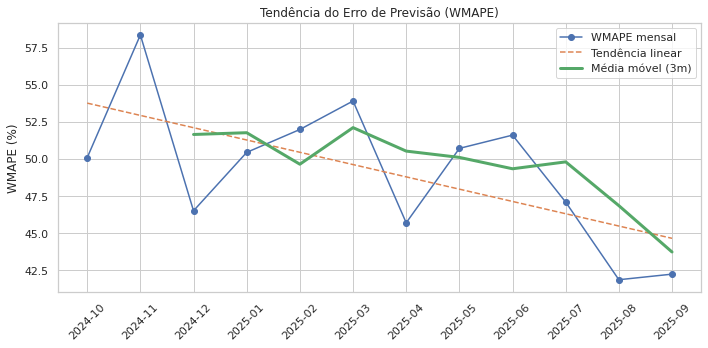

Inclinação da tendência (β): -0.828
Meses de pico identificados: ['2025-06', '2025-03', '2025-07']


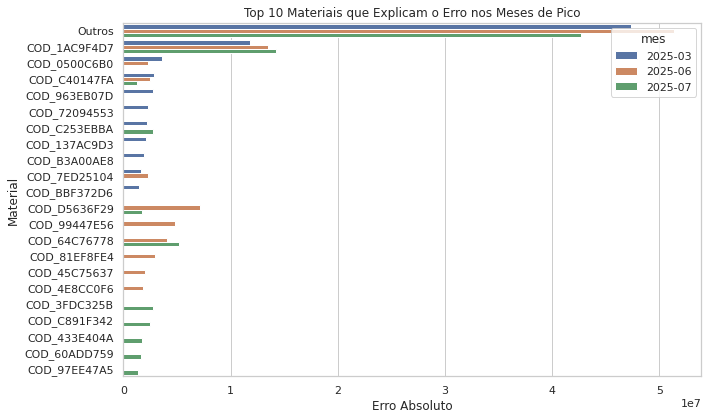

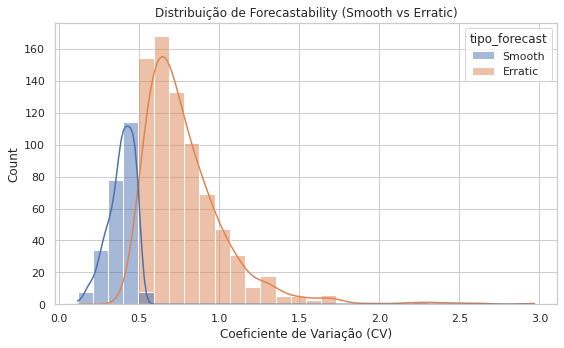

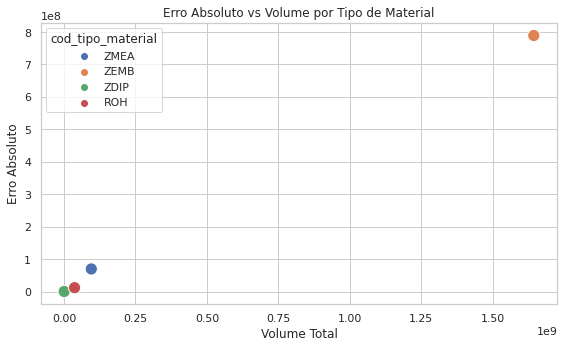

In [0]:
sns.set(style="whitegrid")

# =========================================================
# 1. WMAPE MENSAL + TENDÊNCIA
# =========================================================
df_trend = spark.sql("""
    SELECT
        date_format(ano_mes, 'yyyy-MM') AS mes,
        SUM(ABS(qtd_realizada - qtd_prevista)) /
        SUM(qtd_realizada) * 100 AS wmape_mensal
    FROM sandbox.consumo_material_base
    WHERE qtd_realizada > 0
    GROUP BY 1
    ORDER BY 1
""").toPandas()

df_trend["t"] = range(len(df_trend))
coef = np.polyfit(df_trend["t"], df_trend["wmape_mensal"], 1)
df_trend["tendencia"] = np.polyval(coef, df_trend["t"])
df_trend["mm_3"] = df_trend["wmape_mensal"].rolling(3).mean()

plt.figure(figsize=(10,5))
plt.plot(df_trend["mes"], df_trend["wmape_mensal"], marker="o", label="WMAPE mensal")
plt.plot(df_trend["mes"], df_trend["tendencia"], linestyle="--", label="Tendência linear")
plt.plot(df_trend["mes"], df_trend["mm_3"], linewidth=3, label="Média móvel (3m)")
plt.title("Tendência do Erro de Previsão (WMAPE)")
plt.ylabel("WMAPE (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Inclinação da tendência (β): {coef[0]:.3f}")

# =========================================================
# 2. IDENTIFICAÇÃO DOS MESES DE PICO
# =========================================================
df_picos = spark.sql("""
    WITH erro_mensal AS (
        SELECT
            date_format(ano_mes, 'yyyy-MM') AS mes,
            SUM(ABS(qtd_realizada - qtd_prevista)) AS erro_total
        FROM sandbox.consumo_material_base
        WHERE qtd_realizada > 0
        GROUP BY 1
    )
    SELECT *
    FROM erro_mensal
    ORDER BY erro_total DESC
    LIMIT 3
""").toPandas()

meses_pico = df_picos["mes"].tolist()
print("Meses de pico identificados:", meses_pico)

# =========================================================
# 3. DECOMPOSIÇÃO DOS PICOS POR MATERIAL (TOP N + OUTROS)
# =========================================================
TOP_N = 10

df_picos_material = spark.sql(f"""
    WITH base AS (
        SELECT
            date_format(ano_mes, 'yyyy-MM') AS mes,
            cod_material,
            ABS(qtd_realizada - qtd_prevista) AS erro_abs
        FROM sandbox.consumo_material_base
        WHERE qtd_realizada > 0
          AND date_format(ano_mes, 'yyyy-MM') IN ({','.join([f"'{m}'" for m in meses_pico])})
    ),

    ranked AS (
        SELECT
            mes,
            cod_material,
            SUM(erro_abs) AS erro_material,
            ROW_NUMBER() OVER (
                PARTITION BY mes
                ORDER BY SUM(erro_abs) DESC
            ) AS rk
        FROM base
        GROUP BY mes, cod_material
    )

    SELECT
        mes,
        CASE
            WHEN rk <= {TOP_N} THEN cod_material
            ELSE 'Outros'
        END AS material,
        SUM(erro_material) AS erro_total
    FROM ranked
    GROUP BY mes, material
    ORDER BY mes, erro_total DESC
""").toPandas()

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_picos_material,
    x="erro_total",
    y="material",
    hue="mes"
)
plt.title(f"Top {TOP_N} Materiais que Explicam o Erro nos Meses de Pico")
plt.xlabel("Erro Absoluto")
plt.ylabel("Material")
plt.tight_layout()
plt.show()

# =========================================================
# 4. FORECASTABILITY — ERRATIC vs SMOOTH
# =========================================================
df_cv = spark.sql("""
    SELECT
        cod_material,
        AVG(qtd_realizada) AS media_consumo,
        STDDEV(qtd_realizada) AS std_consumo,
        STDDEV(qtd_realizada) / AVG(qtd_realizada) AS cv
    FROM sandbox.consumo_material_base
    WHERE qtd_realizada > 0
    GROUP BY cod_material
""").toPandas()

df_cv["tipo_forecast"] = np.where(df_cv["cv"] < 0.5, "Smooth", "Erratic")

plt.figure(figsize=(8,5))
sns.histplot(df_cv, x="cv", hue="tipo_forecast", bins=30, kde=True)
plt.title("Distribuição de Forecastability (Smooth vs Erratic)")
plt.xlabel("Coeficiente de Variação (CV)")
plt.tight_layout()
plt.show()

# =========================================================
# 5. ERRO CONCENTRADO POR TIPO DE MATERIAL (ROH, ZDIP, ETC.)
# =========================================================
df_tipo = spark.sql("""
    SELECT
        cod_tipo_material,
        SUM(ABS(qtd_realizada - qtd_prevista)) AS erro_total,
        SUM(qtd_realizada) AS volume_total
    FROM sandbox.consumo_material_base
    WHERE qtd_realizada > 0
    GROUP BY cod_tipo_material
""").toPandas()

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_tipo,
    x="volume_total",
    y="erro_total",
    hue="cod_tipo_material",
    s=150
)
plt.title("Erro Absoluto vs Volume por Tipo de Material")
plt.xlabel("Volume Total")
plt.ylabel("Erro Absoluto")
plt.tight_layout()
plt.show()


##TABELA DASHBOARD

In [0]:
%sql
CREATE OR REPLACE TABLE sandbox.forecast_health_dashboard AS

WITH base AS (
    SELECT
        ano_mes,
        des_familia,
        cod_tipo_material,
        cod_material,
        qtd_realizada,
        qtd_prevista,
        vlr_consumo_realizado,
        ABS(qtd_realizada - qtd_prevista) AS erro_abs
    FROM sandbox.consumo_material_base
    WHERE qtd_realizada > 0
),

-- =====================================================
-- AGREGAÇÃO PRINCIPAL (NÍVEL FAMÍLIA / MÊS)
-- =====================================================
agregado AS (
    SELECT
        ano_mes,
        des_familia,
        cod_tipo_material,

        SUM(qtd_realizada) AS volume_realizado,
        SUM(qtd_prevista) AS volume_previsto,
        SUM(vlr_consumo_realizado) AS valor_consumo_realizado,

        SUM(erro_abs) AS erro_absoluto,
        SUM(erro_abs) / SUM(qtd_realizada) * 100 AS wmape
    FROM base
    GROUP BY ano_mes, des_familia, cod_tipo_material
),

-- =====================================================
-- PARETO FINANCEIRO (VALOR CONSUMIDO)
-- =====================================================
pareto AS (
    SELECT
        ano_mes,
        des_familia,
        valor_consumo_realizado,
        SUM(valor_consumo_realizado) OVER (
            PARTITION BY ano_mes
            ORDER BY valor_consumo_realizado DESC
        ) /
        SUM(valor_consumo_realizado) OVER (PARTITION BY ano_mes)
        AS pct_acumulado_valor
    FROM agregado
),

-- =====================================================
-- CV POR MATERIAL (CORRETO)
-- =====================================================
cv_material AS (
    SELECT
        cod_material,
        des_familia,
        STDDEV(qtd_realizada) / AVG(qtd_realizada) AS cv_material
    FROM sandbox.consumo_material_base
    WHERE qtd_realizada > 0
    GROUP BY cod_material, des_familia
),

-- =====================================================
-- FORECASTABILITY POR MATERIAL
-- =====================================================
forecast_material AS (
    SELECT
        cod_material,
        des_familia,
        cv_material,
        CASE
            WHEN cv_material < 0.6 THEN 'Smooth'
            WHEN cv_material < 1.0 THEN 'Intermittent'
            ELSE 'Erratic'
        END AS forecastability_material
    FROM cv_material
),

-- =====================================================
-- FORECASTABILITY POR FAMÍLIA (COMPOSIÇÃO)
-- =====================================================
forecast_familia AS (
    SELECT
        des_familia,

        COUNT(*) AS total_materiais,

        SUM(CASE WHEN forecastability_material = 'Smooth' THEN 1 ELSE 0 END) AS qtd_smooth,
        SUM(CASE WHEN forecastability_material = 'Intermittent' THEN 1 ELSE 0 END) AS qtd_intermittent,
        SUM(CASE WHEN forecastability_material = 'Erratic' THEN 1 ELSE 0 END) AS qtd_erratic,

        CASE
            WHEN SUM(CASE WHEN forecastability_material = 'Erratic' THEN 1 ELSE 0 END) / COUNT(*) >= 0.5
                THEN 'Erratic'
            WHEN SUM(CASE WHEN forecastability_material = 'Intermittent' THEN 1 ELSE 0 END) / COUNT(*) >= 0.5
                THEN 'Intermittent'
            ELSE 'Smooth'
        END AS forecastability_familia
    FROM forecast_material
    GROUP BY des_familia
),

-- =====================================================
-- WMAPE MENSAL POR FAMÍLIA
-- =====================================================
wmape_familia_mes AS (
    SELECT
        ano_mes,
        des_familia,
        SUM(erro_abs) / SUM(qtd_realizada) * 100 AS wmape_mensal
    FROM base
    GROUP BY ano_mes, des_familia
),

-- =====================================================
-- ÍNDICE TEMPORAL
-- =====================================================
wmape_indexado AS (
    SELECT
        ano_mes,
        des_familia,
        wmape_mensal,
        ROW_NUMBER() OVER (
            PARTITION BY des_familia
            ORDER BY ano_mes
        ) AS t
    FROM wmape_familia_mes
),

-- =====================================================
-- TENDÊNCIA DE ERRO
-- =====================================================
tendencia AS (
    SELECT
        des_familia,
        REGR_SLOPE(wmape_mensal, t) AS slope_wmape
    FROM wmape_indexado
    GROUP BY des_familia
)

-- =====================================================
-- TABELA FINAL (DASHBOARD)
-- =====================================================
SELECT
    a.ano_mes,
    a.des_familia,
    a.cod_tipo_material,

    -- Métricas base
    a.volume_realizado,
    a.volume_previsto,
    a.valor_consumo_realizado,
    a.erro_absoluto,
    a.wmape,

    -- Pareto financeiro
    p.pct_acumulado_valor,
    CASE
        WHEN p.pct_acumulado_valor <= 0.8 THEN 'A'
        WHEN p.pct_acumulado_valor <= 0.95 THEN 'B'
        ELSE 'C'
    END AS classe_pareto_valor,

    -- Forecastability
    f.forecastability_familia AS forecastability,

    -- Tendência
    t.slope_wmape,
    CASE
        WHEN t.slope_wmape < -0.2 THEN 'Melhora'
        WHEN t.slope_wmape >  0.2 THEN 'Piora'
        ELSE 'Estável'
    END AS tendencia_erro,

    -- FLAGS
    CASE
        WHEN p.pct_acumulado_valor <= 0.8
         AND f.forecastability_familia = 'Smooth'
         AND a.wmape >= 35
        THEN 1 ELSE 0
    END AS flag_quick_win,

    CASE
        WHEN f.forecastability_familia IN ('Erratic','Intermittent')
         AND p.pct_acumulado_valor <= 0.95
        THEN 1 ELSE 0
    END AS flag_revisao_estrutural,

    -- PESO DE NEGÓCIO
    CASE a.cod_tipo_material
        WHEN 'ROH'  THEN 1.3
        WHEN 'ZEMB' THEN 1.2
        WHEN 'ZDIP' THEN 1.1
        ELSE 1.0
    END AS peso_negocio,

    -- IMPACTO FINAL (CHAVE DO DASHBOARD)
    a.erro_absoluto *
    CASE a.cod_tipo_material
        WHEN 'ROH'  THEN 1.3
        WHEN 'ZEMB' THEN 1.2
        WHEN 'ZDIP' THEN 1.1
        ELSE 1.0
    END AS impacto_ponderado

FROM agregado a
LEFT JOIN pareto p
    ON a.ano_mes = p.ano_mes
   AND a.des_familia = p.des_familia
LEFT JOIN forecast_familia f
    ON a.des_familia = f.des_familia
LEFT JOIN tendencia t
    ON a.des_familia = t.des_familia;


num_affected_rows,num_inserted_rows


/databricks/spark/python/pyspark/sql/pandas/utils.py:124: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [peso_negocio] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


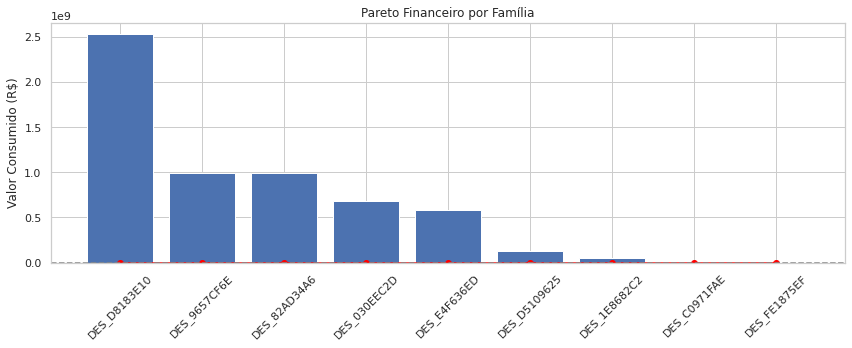

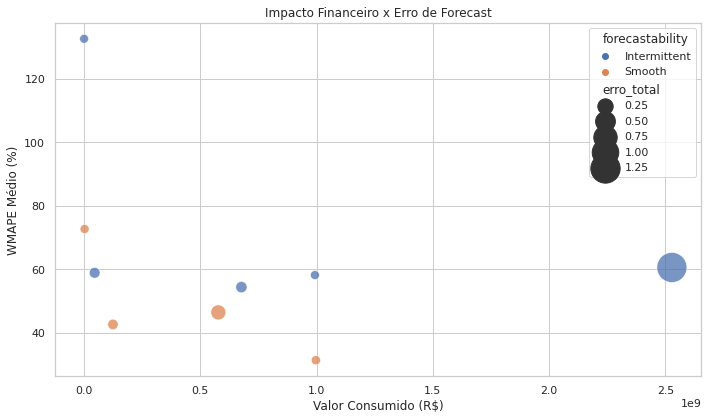

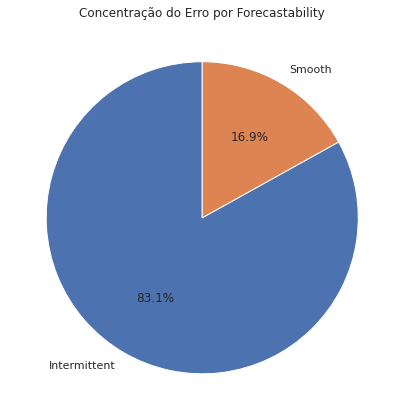

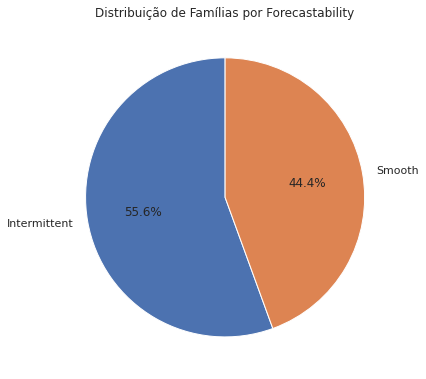

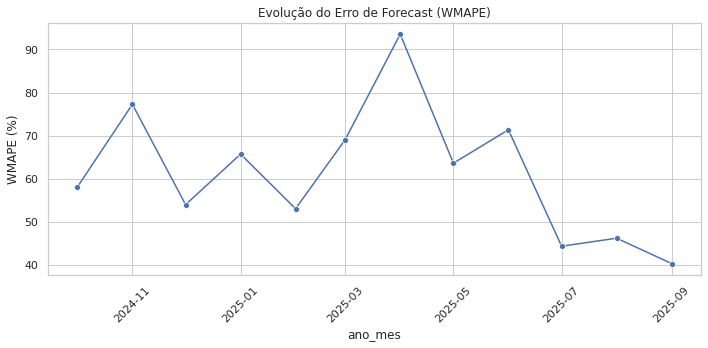

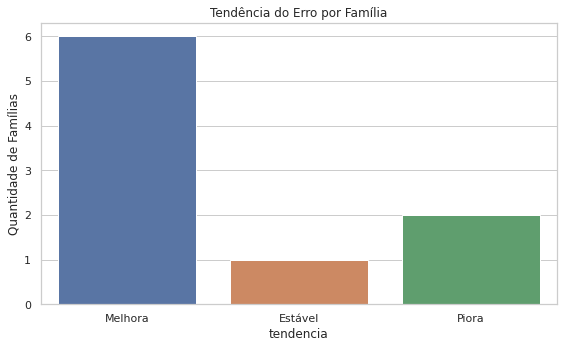

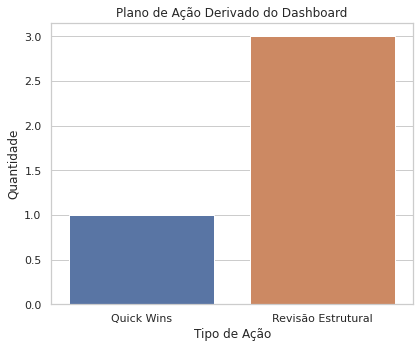

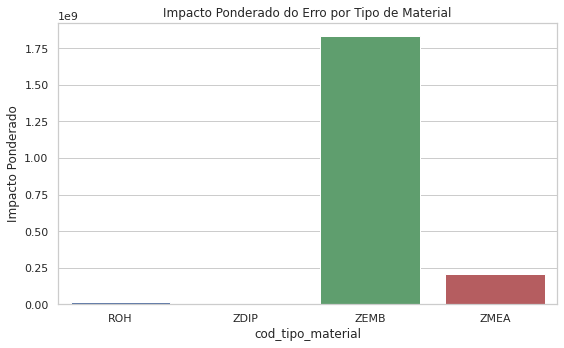

In [0]:
# =====================================================
# FORECAST HEALTH DASHBOARD — SCRIPT ÚNICO
# Fonte: sandbox.forecast_health_dashboard
# =====================================================
sns.set(style="whitegrid")

# =====================================================
# LOAD DATA
# =====================================================
df = spark.table("sandbox.forecast_health_dashboard").toPandas()

# =====================================================
# 1. PARETO FINANCEIRO POR FAMÍLIA
# =====================================================
pareto = (
    df.groupby("des_familia", as_index=False)
      .agg(valor_total=("valor_consumo_realizado", "sum"))
      .sort_values("valor_total", ascending=False)
)

pareto["pct_acumulado"] = pareto["valor_total"].cumsum() / pareto["valor_total"].sum()

plt.figure(figsize=(12,5))
plt.bar(pareto["des_familia"], pareto["valor_total"])
plt.plot(pareto["des_familia"], pareto["pct_acumulado"], color="red", marker="o")
plt.axhline(0.8, linestyle="--", color="gray")
plt.title("Pareto Financeiro por Família")
plt.ylabel("Valor Consumido (R$)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =====================================================
# 2. IMPACTO FINANCEIRO x ERRO (WMAPE)
# =====================================================
impacto = (
    df.groupby("des_familia", as_index=False)
      .agg(
          valor_total=("valor_consumo_realizado", "sum"),
          erro_total=("erro_absoluto", "sum"),
          wmape_medio=("wmape", "mean"),
          forecastability=("forecastability", "first")
      )
)

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=impacto,
    x="valor_total",
    y="wmape_medio",
    size="erro_total",
    hue="forecastability",
    sizes=(80, 900),
    alpha=0.75
)
plt.title("Impacto Financeiro x Erro de Forecast")
plt.xlabel("Valor Consumido (R$)")
plt.ylabel("WMAPE Médio (%)")
plt.tight_layout()
plt.show()

# =====================================================
# 3. CONCENTRAÇÃO DO ERRO — ERRATIC x SMOOTH
# =====================================================
erro_forecast = (
    df.groupby("forecastability", as_index=False)
      .agg(erro_total=("erro_absoluto", "sum"))
)

plt.figure(figsize=(6,6))
plt.pie(
    erro_forecast["erro_total"],
    labels=erro_forecast["forecastability"],
    autopct="%.1f%%",
    startangle=90
)
plt.title("Concentração do Erro por Forecastability")
plt.tight_layout()
plt.show()

# =====================================================
# 4. DISTRIBUIÇÃO DE FAMÍLIAS — ERRATIC x SMOOTH
# =====================================================
dist_fam = (
    df[["des_familia", "forecastability"]]
      .drop_duplicates()
      .groupby("forecastability", as_index=False)
      .count()
      .rename(columns={"des_familia": "qtd_familias"})
)

plt.figure(figsize=(6,6))
plt.pie(
    dist_fam["qtd_familias"],
    labels=dist_fam["forecastability"],
    autopct="%.1f%%",
    startangle=90
)
plt.title("Distribuição de Famílias por Forecastability")
plt.tight_layout()
plt.show()

# =====================================================
# 5. EVOLUÇÃO DO ERRO (WMAPE) AO LONGO DO TEMPO
# =====================================================
trend = (
    df.groupby("ano_mes", as_index=False)
      .agg(wmape_medio=("wmape", "mean"))
)

plt.figure(figsize=(10,5))
sns.lineplot(data=trend, x="ano_mes", y="wmape_medio", marker="o")
plt.title("Evolução do Erro de Forecast (WMAPE)")
plt.ylabel("WMAPE (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =====================================================
# 6. TENDÊNCIA DE ERRO POR FAMÍLIA
# =====================================================
trend_fam = (
    df.groupby("des_familia", as_index=False)
      .agg(
          tendencia=("tendencia_erro", "first"),
          wmape_medio=("wmape", "mean")
      )
)

plt.figure(figsize=(8,5))
sns.countplot(
    data=trend_fam,
    x="tendencia",
    order=["Melhora", "Estável", "Piora"]
)
plt.title("Tendência do Erro por Família")
plt.ylabel("Quantidade de Famílias")
plt.tight_layout()
plt.show()

# =====================================================
# 7. QUICK WINS x REVISÃO ESTRUTURAL
# =====================================================
acoes = (
    df.groupby("des_familia", as_index=False)
      .agg(
          quick_win=("flag_quick_win", "max"),
          revisao=("flag_revisao_estrutural", "max")
      )
)

acoes_resumo = pd.DataFrame({
    "Tipo de Ação": ["Quick Wins", "Revisão Estrutural"],
    "Quantidade": [
        acoes["quick_win"].sum(),
        acoes["revisao"].sum()
    ]
})

plt.figure(figsize=(6,5))
sns.barplot(data=acoes_resumo, x="Tipo de Ação", y="Quantidade")
plt.title("Plano de Ação Derivado do Dashboard")
plt.tight_layout()
plt.show()

# =====================================================
# 8. IMPACTO PONDERADO POR TIPO DE MATERIAL
# =====================================================
impacto_tipo = (
    df.groupby("cod_tipo_material", as_index=False)
      .agg(impacto_total=("impacto_ponderado", "sum"))
)

plt.figure(figsize=(8,5))
sns.barplot(
    data=impacto_tipo,
    x="cod_tipo_material",
    y="impacto_total"
)
plt.title("Impacto Ponderado do Erro por Tipo de Material")
plt.ylabel("Impacto Ponderado")
plt.tight_layout()
plt.show()


In [0]:
%sql
select * from sandbox.forecast_health_dashboard

ano_mes,des_familia,cod_tipo_material,volume_realizado,volume_previsto,valor_consumo_realizado,erro_absoluto,wmape,pct_acumulado_valor,classe_pareto_valor,forecastability,slope_wmape,tendencia_erro,flag_quick_win,flag_revisao_estrutural,peso_negocio,impacto_ponderado
2025-02-01,DES_E4F636ED,ZEMB,3.96276237E7,3.8181145E7,5.08827559E7,2.670013150000001E7,67.37757404312893,0.95145439736276,C,Smooth,-1.3197469023354547,Melhora,0,0,1.2,3.2040157800000012E7
2024-10-01,DES_82AD34A6,ROH,301142.15,256439.80000000005,9.176472949999997E7,149605.05,49.679212956406126,0.2524746639957999,A,Intermittent,-0.72309154717062,Melhora,0,1,1.3,194486.565
2025-06-01,DES_D8183E10,ZDIP,35790.30000000002,36770.5,1361288.4,15799.4,44.144363137498125,0.9997022259706554,C,Intermittent,-0.8405455138703585,Melhora,0,0,1.1,17379.34
2025-06-01,DES_D8183E10,ZDIP,35790.30000000002,36770.5,1361288.4,15799.4,44.144363137498125,0.99845182103311,C,Intermittent,-0.8405455138703585,Melhora,0,0,1.1,17379.34
2025-06-01,DES_D8183E10,ZDIP,35790.30000000002,36770.5,1361288.4,15799.4,44.144363137498125,0.6885496169257188,A,Intermittent,-0.8405455138703585,Melhora,0,1,1.1,17379.34
2025-03-01,DES_FE1875EF,ZDIP,291.8,473.3,13237.5,181.5,62.20013708019191,0.9999999999999998,C,Intermittent,8.469440388560182,Piora,0,0,1.1,199.65
2025-06-01,DES_D5109625,ZEMB,8838083.399999999,9414570.5,1.02758835E7,2334281.5,26.411625624623554,0.9838589573370461,C,Smooth,-0.7116894393542568,Melhora,0,0,1.2,2801137.8
2025-04-01,DES_D8183E10,ZMEA,1.2580827000000002E7,8479704.7,513859.60000000003,7184594.1,57.10748665409674,0.9995204875216867,C,Intermittent,-0.8405455138703585,Melhora,0,0,1.0,7184594.1
2025-04-01,DES_D8183E10,ZMEA,1.2580827000000002E7,8479704.7,513859.60000000003,7184594.1,57.10748665409674,0.9980401167454159,C,Intermittent,-0.8405455138703585,Melhora,0,0,1.0,7184594.1
2025-04-01,DES_D8183E10,ZMEA,1.2580827000000002E7,8479704.7,513859.60000000003,7184594.1,57.10748665409674,0.6933120692086467,A,Intermittent,-0.8405455138703585,Melhora,0,1,1.0,7184594.1


##EXPLORAÇÃO ERRATIC E SMOOTH

In [0]:
# ===============================
# ERRO POR FORECASTABILITY
# ===============================

df_err_forecast = spark.sql("""
    WITH base AS (
        SELECT
            cod_material,
            qtd_realizada,
            qtd_prevista,
            ABS(qtd_realizada - qtd_prevista) AS erro_abs
        FROM sandbox.consumo_material_base
        WHERE qtd_realizada > 0
    ),

    cv_material AS (
        SELECT
            cod_material,
            STDDEV(qtd_realizada) / AVG(qtd_realizada) AS cv
        FROM sandbox.consumo_material_base
        WHERE qtd_realizada > 0
        GROUP BY cod_material
    ),

    joined AS (
        SELECT
            b.erro_abs,
            b.qtd_realizada,
            CASE
                WHEN c.cv < 0.5 THEN 'Smooth'
                ELSE 'Erratic'
            END AS forecastability
        FROM base b
        JOIN cv_material c
            ON b.cod_material = c.cod_material
    )

    SELECT
        forecastability,
        SUM(erro_abs) AS erro_absoluto_total,
        SUM(qtd_realizada) AS volume_total,
        SUM(erro_abs) / SUM(qtd_realizada) * 100 AS wmape
    FROM joined
    GROUP BY forecastability
""").toPandas()


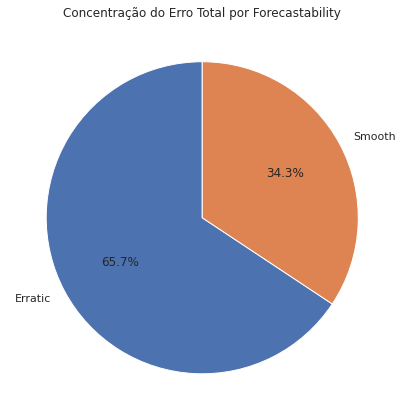

In [0]:
df_err_forecast["pct_erro"] = (
    df_err_forecast["erro_absoluto_total"] /
    df_err_forecast["erro_absoluto_total"].sum() * 100
)

plt.figure(figsize=(6,6))
plt.pie(
    df_err_forecast["pct_erro"],
    labels=df_err_forecast["forecastability"],
    autopct="%.1f%%",
    startangle=90,
    colors=["#4C72B0", "#DD8452"]
)
plt.title("Concentração do Erro Total por Forecastability")
plt.tight_layout()
plt.show()


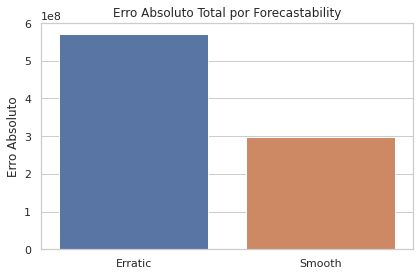

In [0]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=df_err_forecast,
    x="forecastability",
    y="erro_absoluto_total",
    palette=["#4C72B0", "#DD8452"]
)

plt.title("Erro Absoluto Total por Forecastability")
plt.ylabel("Erro Absoluto")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

df_material_forecast = spark.sql("""
    WITH cv_material AS (
        SELECT
            cod_material,
            STDDEV(qtd_realizada) / AVG(qtd_realizada) AS cv
        FROM sandbox.consumo_material_base
        WHERE qtd_realizada > 0
        GROUP BY cod_material
    )
    SELECT
        CASE
            WHEN cv < 0.5 THEN 'Smooth'
            ELSE 'Erratic'
        END AS forecastability,
        COUNT(*) AS qtd_materiais
    FROM cv_material
    GROUP BY forecastability
""").toPandas()


In [0]:
df_material_forecast["pct_materiais"] = (
    df_material_forecast["qtd_materiais"] /
    df_material_forecast["qtd_materiais"].sum() * 100
)


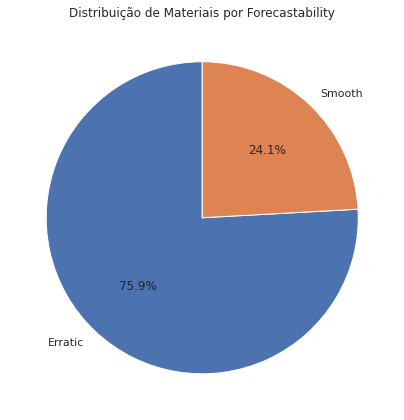

In [0]:
plt.figure(figsize=(6,6))
plt.pie(
    df_material_forecast["pct_materiais"],
    labels=df_material_forecast["forecastability"],
    autopct="%.1f%%",
    startangle=90,
    colors=["#4C72B0", "#DD8452"]
)
plt.title("Distribuição de Materiais por Forecastability")
plt.tight_layout()
plt.show()
